In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-chi-kmeans-balanced/yelp_chi_X_tf_idf_balanced.csv
/kaggle/input/yelp-chi-kmeans-balanced/Наивный Байес_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/Метод ближайших соседей_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/Случайный лес_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/Логистическая регрессия_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/Мини-пакетный метод стохастического градиентного спуска_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/yelp_chi_kmeans_balancing.csv
/kaggle/input/yelp-chi-kmeans-balanced/Машина опорных векторов_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/yelp_chi_y_labels_balanced.csv
/kaggle/input/yelp-chi-kmeans-balanced/LogisticRegression с подбором параметров_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/Voting-классификатор_confusion_matrix.png
/kaggle/input/yelp-chi-kmeans-balanced/RandomForest_confusion_matrix.png
/kaggle/input/glove-

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/word

In [3]:

def set_seed(seed: int = 42):
    import random
    """
    Фиксирует seed для всех источников случайности.

    Args:
        seed (int): Значение seed.
    """
    # Python's random module
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    
    # Если используется CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Для multi-GPU.

In [4]:
set_seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/yelp-chi-kmeans-balanced/yelp_chi_kmeans_balancing.csv')
df

,Unnamed: 0.1,Unnamed: 0,date,review_id,user_id,prod_id,label,useful,funny,cool,rating,review
0,1581,1581,8/3/2009,ecTm3Ba2TMRLxX5GWgsbHg,93nVXkxIFNSFVVv0rnYaVA,HOJqzz1WvOmeR9oESJ4d9A,1,0,1,1,4,There is nothing i can say that hasn't been sa...
1,23622,23622,7/19/2011,ZDcj8ExyLa1swbz9S7IuaA,CWit5YsPTkh6zfbI3l1trg,yBRaSkuYwFhYEoucDyD0lA,1,0,2,1,5,It's no secret that I love this place. I have ...
2,1804,1804,5/2/2011,MuR4YGNBMxNJMkLIxsvPpQ,FkECUA0uN5R99KZO65YM1Q,HOJqzz1WvOmeR9oESJ4d9A,1,2,1,1,5,"Amazing Dogs! Vesuvial, and satisfying garlic ..."
3,21608,21608,2/4/2012,UCvuuOahBAAkc9bWy2xxjQ,F1a_gzV-V9oqq-yHKHPTBQ,FCcgXODBs6O7MGH3VZNyLQ,1,0,0,0,1,"Superdawg rocks, don't listen to all the ""it d..."
4,35263,35263,2/13/2012,HSrHOE8ES3,b5Cq89YxAqaS-5ceCk8y9Q,KomhK0JD5cleEW55YTw7MQ,1,0,0,2,1,"If you have not yet been to Shaw's Crab House,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15579,61408,61408,3/2/2012,Hr0bENBZzznWhYGKSSEEJA,i2Th0Zskb4Ry_aVZQMIR_Q,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,"Great food and good service. It's BYOB, so bri..."
15580,61409,61409,2/18/2012,qGvPCsS3krxl5O5fo9Qasw,UqTtumV5SGzzW2gtJc-fNg,mCHto10PBQOKnefm7gholg,-1,0,0,0,1,This is a must dine restaurant. After we saw t...
15581,61410,61410,12/31/2011,znZdvMF_Q-rCT3ih3-AQAg,Y-yZy5TWmWrC6mlY_BaseQ,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,I came here about 5 times and the food is alwa...
15582,61411,61411,12/17/2011,tgbjSaEGOGyV6q1y13Mi8Q,Yva1UlQvZ-MGfJEQMWrk8Q,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,So delicious! Ordered this in and got yellow c...


In [6]:
reviews_texts = df[['review', 'label']]
reviews_texts.isna().sum()

review    0
label     0
dtype: int64

In [7]:
# x_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_X_tf_idf_balanced.csv')

In [8]:
# x_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
# y_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_y_labels_balanced.csv')

In [10]:
# y_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression


In [12]:
# X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(x_tfidf, y_tfidf, test_size=0.2, random_state=42)

In [13]:
# X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

In [14]:
# lr =  LogisticRegression(random_state=42)

# lr.fit(X_train_tfidf, y_train_tfidf)

In [15]:
# y_pred = lr.predict(X_test_tfidf)

In [16]:
# from sklearn.metrics import classification_report

# print(classification_report(y_test_tfidf, y_pred))

# Базовая предобработка текстов

In [17]:
! pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.8 MB/s eta 0:00:00


In [18]:
import re
import contractions

stop_words = set(stopwords.words('english'))
def preprocess_review(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\d'\s]", '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

text = "This is an example for wifes test 145 13 we're don't"
preprocess_review(text)

'example wifes test 145 13'

In [19]:
reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)

<ipython-input-19-b428cbb01f8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)


In [20]:
reviews_texts['review'].head(10)

0    nothing say said hot doug 's already pretty mu...
1    secret love place brought various friends ladi...
2    amazing dogs vesuvial satisfying garlic belche...
3    superdawg rocks listen live hype yelpers expec...
4    yet shaw 's crab house get decided make shaw '...
5    came best buddy last day chicago two weeks ago...
6    saw hot doug 's food channel 's hot dog mecca ...
7    particularly unfortunate day hubs said screw l...
8    absolutely love art pizza went girlfriends pri...
9    agree nicole wanted try 20th birthday booked t...
Name: review, dtype: object

In [21]:
for r in reviews_texts['review']:
    splitted_r = r.split()
    short_reviews_list = []
    if len(splitted_r)<300:
        short_review = ' '.join(splitted_r)
        short_reviews_list.append(short_review)

print(len(short_reviews_list))
print(len(short_reviews_list[0].split()))


1
40


# Torch классы и функции

In [22]:
import matplotlib.pyplot as plt

In [23]:
def load_embedding_from_file(path_to_embedding):
    embeddings = {}
    with open(path_to_embedding, 'r', encoding='utf-8') as f:
        for line in f:
            splitted_line = line.strip().split()
            word = splitted_line[0]
            vector = np.array(splitted_line[1:])
            # print(word, vector, vector.shape)
            embeddings[word] = vector
    return embeddings
    

In [24]:
from collections import Counter

def build_vocabulary_and_embeddings(reviews, embeddings:dict, embedding_dim:int):
    vocabulary = {
        'PAD' : 0,
        'UKN' : 1,
    }

    counter = Counter()
    not_in_embeddings = []
    for review in reviews:
        counter.update(review.strip().split())
    # print(counter.most_common())

    # Построение словаря. most_common - для аггрегации слов
    for word, _ in counter.most_common():
        if word in embeddings:
            vocabulary[word] = len(vocabulary)
        else:
            not_in_embeddings.append(word)
    print('Кол-во слов, которых нет в эмбеддинге:', len(not_in_embeddings))

    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))    

    for word, index in vocabulary.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
        elif word == 'UKN':
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocabulary, embedding_matrix
    
# vocabulary2, embedding_matrix2 = build_vocabulary_and_embeddings(['very good', 'very nice', 'super good'], 
                                                               # glove_dict, 
                                                               # 300)
# print(vocabulary2)
# print(embedding_matrix2[1])

In [25]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, vocabulary, embedding_matrix, max_len):
        self.reviews = reviews
        self.labels = labels
        self.vocabulary = vocabulary
        self.embedding_matrix = embedding_matrix
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        # работа с токенами в отзыве
        tokens = review.split()[:self.max_len] # берем определенное количество токенов
        inds = [self.vocabulary.get(tok, self.vocabulary['UKN']) for tok in tokens] # вычисляем их индексы
        # заполнение нулями
        padding_length = self.max_len - len(inds)
        inds += [self.vocabulary['PAD']] * padding_length
        return torch.tensor(inds), torch.tensor(label)

In [26]:
import numpy as np
import torch
class Early_stopping:
    def __init__(self, patience=3, delta=0.0, save_path='model_weights.pth'):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            print(f"Best loss: {self.best_loss}")
            self.counter = 0
            torch.save(model.state_dict(), self.save_path) # сохраняем веса наилучшей модели

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered! Best model weights saved.")

In [27]:
def unfreeze_embeddings(model):
    for param in model.embedding.parameters():
         param.requires_grad = True
    print('Embeddings unfreeze')

In [28]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report, confusion_matrix

def compute_metrics(labels, preds):
    # Преобразуем предсказания в вероятности (если нужно)
    # print(preds)
    # preds = [int(p) for p in preds]
    # preds_classes = np.round(probs).astype(int)

    if np.any(np.isnan(preds)):
        print("Warning: NaN values found in predictions!")
        preds = np.nan_to_num(preds)  # Заменяем NaN на 0
    preds_classes = np.round(preds).astype(int)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auc = roc_auc_score(labels, preds) 
    # if len(np.unique(labels)) > 1 else 0.5  # AUC требует обоих классов

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'AUC': auc
    }

def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')    

def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [29]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    # сохраняем историю во время обучения
    history = {
        'train_loss':[],
        'train_accuracy' :[],
        'train_precision':[],
        'train_recall':[],
        'train_F1':[],
        'train_AUC': [],
        'val_loss':[],
        
        'val_accuracy' :[],
        'val_precision':[],
        'val_recall':[],
        'val_F1':[],
        'val_AUC':[]
    }   

    grad_logs = {}
    flag_freeze = False
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0): 
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Режим обучения
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []
        print('-----Обучение-----')
        for inputs, labels in train_loader:
        # with torch.autograd.detect_anomaly():
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad() # обнуляем градиенты для текущего батча
            outputs = model(inputs) # вычисляем выход модели

            # if (epoch == 12) and not(flag_freeze) :
            #     unfreeze_embeddings(model)
            #     flag_freeze = True
            
            
            if torch.any(torch.isnan(outputs)):
                print("NAN значения среди outputs!")
                print(outputs[:4])
                return history, grad_logs
            
            loss = criterion(outputs, labels) # вычисляем loss для батча
            if torch.isnan(loss):
                print("NaN в лоссе!")
                print(f'''
                -----------------------
                -----------------------
                loss: {loss}
                -----------------------
                -----------------------
                inputs: {inputs}
                -----------------------
                -----------------------
                outputs: {outputs}
                -----------------------
                -----------------------
                
                ''')
                return history, grad_logs
            train_losses.append(loss.item()) 
            loss.backward()
                
            # вывод градиента, проверка на взрыв/затухание
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in grad_logs.keys():
                        grad_logs[name] = []    
                    grad_logs[name].append(param.grad.norm().item())
                    
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            
            optimizer.step()

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            if np.any(np.isnan(preds[:4])):
                print("NAN значения среди preds!")
                print(preds)
                return history, grad_logs
            labels = labels.detach().cpu().numpy()
            train_preds.extend(preds.flatten())
            train_labels.extend(labels.flatten())
        # считаем показатели после эпохи
        train_loss = sum(train_losses) / len(train_losses) # среднее на эпохе
        train_metrics = compute_metrics(train_labels, train_preds) # метрики на эпохе
        # сохранем историю после эпохи
        for name, value in train_metrics.items():
            history[f"train_{name}"].append(value)
        history['train_loss'].append(train_loss)
        #======#
        
        # режим валидации
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                val_preds.extend(preds)
                val_labels.extend(labels)
            
            val_loss = sum(val_losses) / len(val_losses)
            val_metrics = compute_metrics(val_labels, val_preds)
            for metric_name, metric_value in val_metrics.items():
                history[f'val_{metric_name}'].append(metric_value)
            history['val_loss'].append(val_loss)
         # Вывод метрик
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_metrics["accuracy"]:.4f} | ',
              f'Train Precision: {train_metrics["precision"]:.4f} | Train Recall: {train_metrics["recall"]:.4f} | ',
              f'Train F1: {train_metrics["F1"]:.4f} | Train AUC: {train_metrics["AUC"]:.4f}')
        
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_metrics["accuracy"]:.4f} | ',
              f'Val Precision: {val_metrics["precision"]:.4f} | Val Recall: {val_metrics["recall"]:.4f} | ',
              f'Val F1: {val_metrics["F1"]:.4f} | Val AUC: {val_metrics["AUC"]:.4f}')

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f'Stop after {epoch} epochs')
                return history, grad_logs
        
    return history, grad_logs

In [30]:
def plot_metrics(history, model_name):
    """
    Визуализирует метрики из словаря history.

    :param history: Словарь, содержащий метрики обучения и валидации.
    """
    # Проверяем, есть ли данные для визуализации
    if not history:
        print("Словарь history пуст.")
        return

    # Извлекаем метрики из history
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    train_metrics = [f'train_{metric}' for metric in metrics]
    val_metrics = [f'val_{metric}' for metric in metrics]

    # Создаём графики для каждой метрики
    plt.figure(figsize=(15, 10))
    plt.title(f"Процесс обучения {model_name}")
    for i, (metric, val_metric) in enumerate(zip(train_metrics, val_metrics)):
        plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика
        if metric in history:
            plt.plot(history[metric], label=f'Обучение')
        if val_metric in history:
            plt.plot(history[val_metric], label=f'Валидация')

        plt.title(metric.capitalize()[6:])
        plt.xlabel('Эпохи')
        plt.ylabel("Значения метрики")
        plt.legend()
    plt.savefig(f'Процесс обучения {model_name}')
    plt.tight_layout()
    plt.show()

In [31]:
def eval_model(model, test_loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating(test)"):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    metrics = compute_metrics(all_labels, all_preds)
    metrics['loss'] = sum(losses) / len(losses)
    return sum(losses) / len(losses), metrics, all_labels, all_preds
            

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_eval(history_dict, model_name):
    keys = list(history_dict.keys())
    values = list(map(lambda x: round(x, 4), list(history_dict.values())))
    
    print(keys)
    print(values)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x=keys, y=values)
    plt.xlabel('Метрики')
    plt.ylabel('Значения метрик')
    plt.title(f'Метрики {model_name} на тестовой выборке')
    for p, l in zip(ax.patches, values):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), l, ha = 'center', va = 'bottom')   
    plt.legend()

    plt.savefig(f'Метрики {model_name} на тестовой выборке.png')
    plt.tight_layout()
    plt.show()

# Предобработка

In [33]:
reviews_texts.head(4)

,review,label
0,nothing say said hot doug 's already pretty mu...,1
1,secret love place brought various friends ladi...,1
2,amazing dogs vesuvial satisfying garlic belche...,1
3,superdawg rocks listen live hype yelpers expec...,1


In [34]:
reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)
reviews_texts.tail(4)


<ipython-input-34-affa42ad5df4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)


,review,label
15580,must dine restaurant saw restaurant television...,0
15581,came 5 times food always consistent best cuban...,0
15582,delicious ordered got yellow curry chicken nug...,0
15583,popped old neighborhood checked lunch one day ...,0


In [35]:
glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_dict = load_embedding_from_file(glove_path)


In [36]:
vocabulary, embedding_matrix = build_vocabulary_and_embeddings(reviews_texts['review'], embeddings=glove_dict, embedding_dim=300)


Кол-во слов, которых нет в эмбеддинге: 23404


In [37]:
print(len(vocabulary))
print(embedding_matrix.shape)
# ukn = vocabulary['UKN']
# print(ukn)
# print(embedding_matrix[ukn])

print(vocabulary.get('qqqqq', vocabulary['UKN']))


27338
(27338, 300)
1


In [38]:
pad = vocabulary['PAD']
print(pad)
print(embedding_matrix[pad])
type(embedding_matrix)

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


numpy.ndarray

In [39]:
vocabulary_keys = list(vocabulary.keys())
not_in_glove = []
for key in vocabulary_keys:
    if key not in glove_dict.keys():
        not_in_glove.append(key)
print(not_in_glove)
    

['PAD', 'UKN']


In [40]:
reviews_texts['review']

0        nothing say said hot doug 's already pretty mu...
1        secret love place brought various friends ladi...
2        amazing dogs vesuvial satisfying garlic belche...
3        superdawg rocks listen live hype yelpers expec...
4        yet shaw 's crab house get decided make shaw '...
                               ...                        
15579    great food good service byob bring bottle wine...
15580    must dine restaurant saw restaurant television...
15581    came 5 times food always consistent best cuban...
15582    delicious ordered got yellow curry chicken nug...
15583    popped old neighborhood checked lunch one day ...
Name: review, Length: 15584, dtype: object

In [41]:
full_dataset = ReviewsDataset(reviews = reviews_texts['review'], 
                             labels = reviews_texts['label'],
                             vocabulary = vocabulary,
                             embedding_matrix = embedding_matrix,
                             max_len = 256
                            )

In [42]:
from torch.utils.data import random_split
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.75, 0.05, 0.2], generator=generator)

print(f"""
Размер тренировочного набора: {len(train_dataset)}, 
Размер валидационного набора: {len(valid_dataset)}, 
Размер тестового набора: {len(test_dataset)}, 
"""
)


Размер тренировочного набора: 11689, 
Размер валидационного набора: 779, 
Размер тестового набора: 3116, 



In [43]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in train_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [44]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in valid_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [45]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in test_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [46]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32)


# Модели

In [47]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [48]:
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:  # Веса входного слоя
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:  # Веса рекуррентного слоя
                init.orthogonal_(param.data)  
            elif 'bias' in name:  # Смещения (bias)
                param.data.fill_(0)

    elif isinstance(m, nn.Linear):  # Полносвязный слой
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)

# Simple LSTM

In [49]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [50]:
simple_lstm_model = nn.Sequential(
    nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32)),
    nn.Dropout(dropout_rate),
    nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True),
    nn.Linear(hidden_dim, output_dim)
)
print(simple_lstm_model)

Sequential(
  (0): Embedding(27338, 300)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(300, 256, batch_first=True)
  (3): Linear(in_features=256, out_features=1, bias=True)
)


## Обучение Simple LSTM

In [51]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTM_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        output = self.fc2(lstm_out)
        return output
        

In [52]:
simple_lstm_model = LSTM_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [53]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=6, delta=0.001, save_path='simple_lstm_model.pth')
simple_lstm_model.to(device)

LSTM_model(
  (embedding): Embedding(27338, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [54]:
history, _ = train_model(model=simple_lstm_model, 
                        train_loader=train_loader,
                        valid_loader=valid_loader, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        device=device, 
                        num_epochs=num_epochs, 
                        early_stopping=early_stopping
                        )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:05<09:36,  5.83s/it]

Train Loss: 0.7132 | Train Acc: 0.5604 |  Train Precision: 0.5991 | Train Recall: 0.2275 |  Train F1: 0.3298 | Train AUC: 0.5448
Val Loss: 0.6692 | Val Acc: 0.5635 |  Val Precision: 0.9143 | Val Recall: 0.0867 |  Val F1: 0.1584 | Val AUC: 0.5397
Best loss: 0.6691794097423553

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:10<08:21,  5.12s/it]

Train Loss: 0.6600 | Train Acc: 0.5797 |  Train Precision: 0.5818 | Train Recall: 0.4114 |  Train F1: 0.4820 | Train AUC: 0.5718
Val Loss: 0.5748 | Val Acc: 0.7073 |  Val Precision: 0.8161 | Val Recall: 0.4932 |  Val F1: 0.6149 | Val AUC: 0.6966
Best loss: 0.5748162791132927

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [00:15<07:57,  4.92s/it]

Train Loss: 0.5972 | Train Acc: 0.6705 |  Train Precision: 0.6863 | Train Recall: 0.5653 |  Train F1: 0.6200 | Train AUC: 0.6656
Val Loss: 0.4050 | Val Acc: 0.8460 |  Val Precision: 0.8716 | Val Recall: 0.7913 |  Val F1: 0.8295 | Val AUC: 0.8432
Best loss: 0.40501387417316437

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [00:19<07:41,  4.81s/it]

Train Loss: 0.3162 | Train Acc: 0.8777 |  Train Precision: 0.8411 | Train Recall: 0.9156 |  Train F1: 0.8768 | Train AUC: 0.8794
Val Loss: 0.2446 | Val Acc: 0.8883 |  Val Precision: 0.8672 | Val Recall: 0.9024 |  Val F1: 0.8845 | Val AUC: 0.8890
Best loss: 0.24455922842025757

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [00:24<07:30,  4.74s/it]

Train Loss: 0.2361 | Train Acc: 0.9103 |  Train Precision: 0.8813 | Train Recall: 0.9377 |  Train F1: 0.9086 | Train AUC: 0.9116
Val Loss: 0.2756 | Val Acc: 0.8703 |  Val Precision: 0.8583 | Val Recall: 0.8699 |  Val F1: 0.8641 | Val AUC: 0.8703

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [00:29<07:22,  4.71s/it]

Train Loss: 0.1886 | Train Acc: 0.9317 |  Train Precision: 0.9002 | Train Recall: 0.9631 |  Train F1: 0.9306 | Train AUC: 0.9332
Val Loss: 0.2849 | Val Acc: 0.8793 |  Val Precision: 0.8463 | Val Recall: 0.9106 |  Val F1: 0.8773 | Val AUC: 0.8809

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [00:33<07:21,  4.74s/it]

Train Loss: 0.1451 | Train Acc: 0.9514 |  Train Precision: 0.9285 | Train Recall: 0.9726 |  Train F1: 0.9501 | Train AUC: 0.9524
Val Loss: 0.3073 | Val Acc: 0.8729 |  Val Precision: 0.8610 | Val Recall: 0.8726 |  Val F1: 0.8668 | Val AUC: 0.8729

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [00:38<07:14,  4.72s/it]

Train Loss: 0.1153 | Train Acc: 0.9624 |  Train Precision: 0.9446 | Train Recall: 0.9782 |  Train F1: 0.9611 | Train AUC: 0.9631
Val Loss: 0.3518 | Val Acc: 0.8691 |  Val Precision: 0.8217 | Val Recall: 0.9241 |  Val F1: 0.8699 | Val AUC: 0.8718

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [00:43<07:09,  4.72s/it]

Train Loss: 0.0920 | Train Acc: 0.9718 |  Train Precision: 0.9563 | Train Recall: 0.9856 |  Train F1: 0.9707 | Train AUC: 0.9724
Val Loss: 0.4166 | Val Acc: 0.8742 |  Val Precision: 0.8362 | Val Recall: 0.9133 |  Val F1: 0.8731 | Val AUC: 0.8762

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [00:47<08:05,  5.33s/it]

Train Loss: 0.0832 | Train Acc: 0.9741 |  Train Precision: 0.9612 | Train Recall: 0.9852 |  Train F1: 0.9731 | Train AUC: 0.9746
Val Loss: 0.4280 | Val Acc: 0.8691 |  Val Precision: 0.8217 | Val Recall: 0.9241 |  Val F1: 0.8699 | Val AUC: 0.8718
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


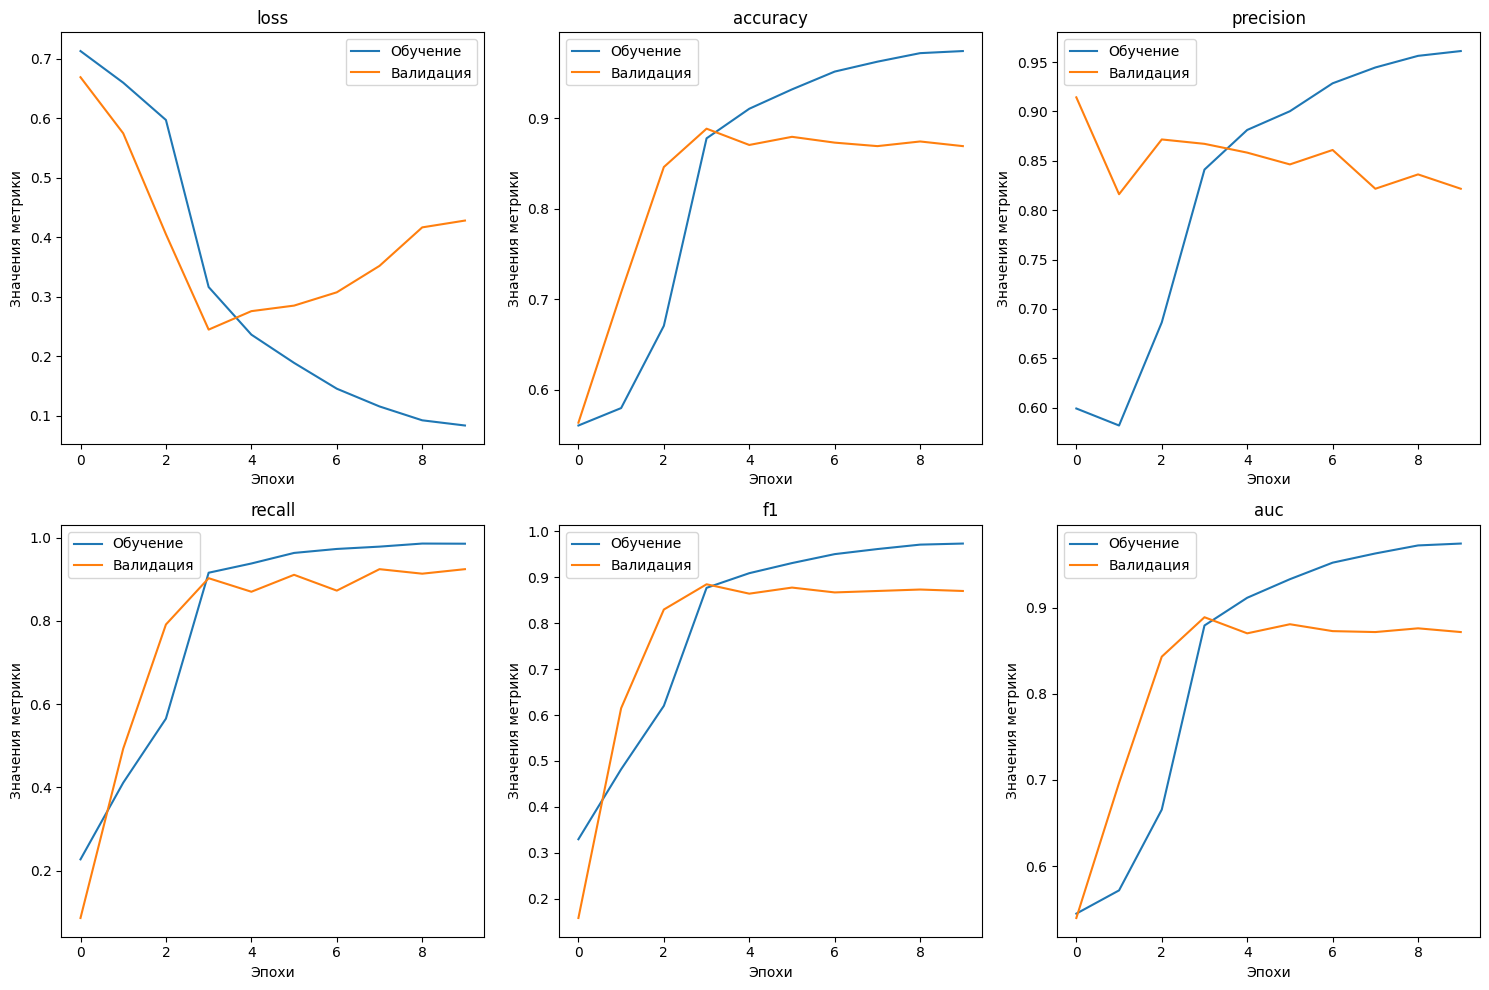

In [55]:
plot_metrics(history, model_name = 'LSTM')

In [56]:
simple_lstm_model.load_state_dict(torch.load('simple_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple LSTM

In [57]:
_, metrics, labels, preds = eval_model(simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 98/98 [00:00<00:00, 108.71it/s]


In [58]:
show_metrics(labels, preds, 'LSTM')


                LSTM
 auc: 0.8925761121032384             
 report:                                
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1598
         1.0       0.88      0.90      0.89      1518

    accuracy                           0.89      3116
   macro avg       0.89      0.89      0.89      3116
weighted avg       0.89      0.89      0.89      3116


    


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8925, 0.8848, 0.8959, 0.8903, 0.8926, 0.2936]


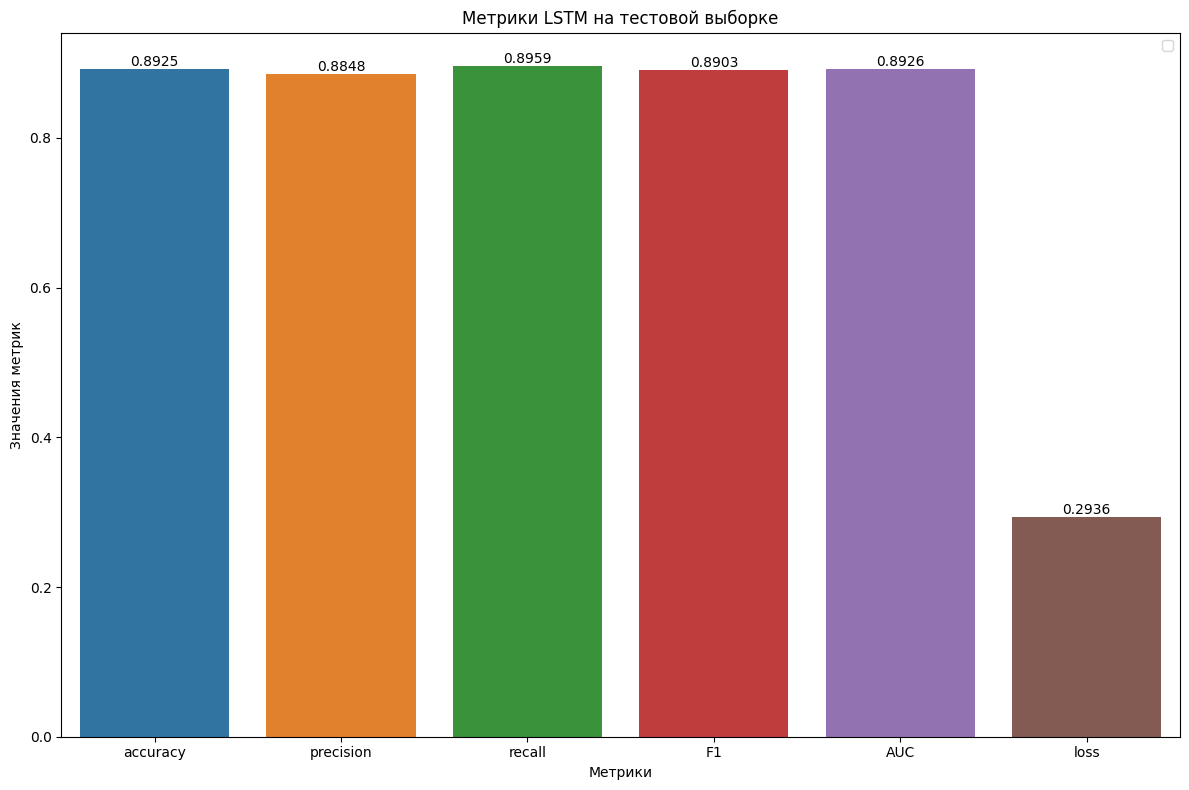

In [59]:
plot_metrics_eval(metrics, 'LSTM')

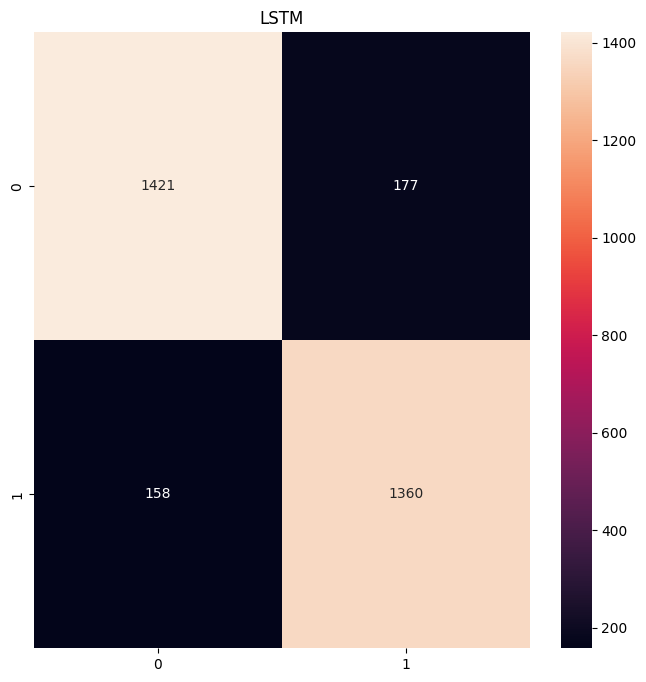

In [60]:
show_confusion_matrix(labels, preds, 'LSTM')

# Simple GRU

In [61]:
class GRU_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(GRU_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           ).to(device)
        # self.fc1 = nn.Linear(hidden_dim, 128).to(device)
        # self.relu = nn.ReLU().to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Берем последний таймстеп
        # fc1_out = self.fc1(lstm_out)
        # fc1_out = self.relu(fc1_out)
        output = self.fc2(gru_out)
        return output
        

## Обучение Simple GRU

In [62]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [63]:
embedding_dim

300

In [64]:

simple_gru_model = GRU_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [65]:
print(simple_gru_model)


GRU_model(
  (embedding): Embedding(27338, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (gru): GRU(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [66]:
simple_gru_model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_gru_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=5, delta=0.0001, save_path = "simple_GRU.pth")


In [67]:
history, grad_logs = train_model(simple_gru_model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:03<06:33,  3.98s/it]

Train Loss: 0.7062 | Train Acc: 0.5677 |  Train Precision: 0.6758 | Train Recall: 0.1740 |  Train F1: 0.2768 | Train AUC: 0.5492
Val Loss: 0.6634 | Val Acc: 0.5700 |  Val Precision: 0.9048 | Val Recall: 0.1030 |  Val F1: 0.1849 | Val AUC: 0.5466
Best loss: 0.663376197218895

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:08<06:35,  4.04s/it]

Train Loss: 0.6579 | Train Acc: 0.5928 |  Train Precision: 0.8522 | Train Recall: 0.1733 |  Train F1: 0.2881 | Train AUC: 0.5730
Val Loss: 0.5601 | Val Acc: 0.7561 |  Val Precision: 0.7609 | Val Recall: 0.7073 |  Val F1: 0.7331 | Val AUC: 0.7537
Best loss: 0.5601121485233307

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [00:12<06:34,  4.07s/it]

Train Loss: 0.4441 | Train Acc: 0.7947 |  Train Precision: 0.7636 | Train Recall: 0.8227 |  Train F1: 0.7921 | Train AUC: 0.7960
Val Loss: 0.3126 | Val Acc: 0.8614 |  Val Precision: 0.7894 | Val Recall: 0.9648 |  Val F1: 0.8683 | Val AUC: 0.8665
Best loss: 0.3126026354730129

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [00:16<06:31,  4.07s/it]

Train Loss: 0.2838 | Train Acc: 0.8837 |  Train Precision: 0.8448 | Train Recall: 0.9251 |  Train F1: 0.8832 | Train AUC: 0.8856
Val Loss: 0.2292 | Val Acc: 0.8922 |  Val Precision: 0.8663 | Val Recall: 0.9133 |  Val F1: 0.8892 | Val AUC: 0.8932
Best loss: 0.2292330302298069

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [00:20<06:27,  4.08s/it]

Train Loss: 0.2369 | Train Acc: 0.9081 |  Train Precision: 0.8714 | Train Recall: 0.9464 |  Train F1: 0.9073 | Train AUC: 0.9099
Val Loss: 0.2118 | Val Acc: 0.9050 |  Val Precision: 0.8753 | Val Recall: 0.9322 |  Val F1: 0.9029 | Val AUC: 0.9064
Best loss: 0.21184846013784409

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [00:24<06:24,  4.09s/it]

Train Loss: 0.2018 | Train Acc: 0.9238 |  Train Precision: 0.8913 | Train Recall: 0.9563 |  Train F1: 0.9226 | Train AUC: 0.9253
Val Loss: 0.2114 | Val Acc: 0.9012 |  Val Precision: 0.9056 | Val Recall: 0.8835 |  Val F1: 0.8944 | Val AUC: 0.9003
Best loss: 0.21142495051026344

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [00:28<06:19,  4.08s/it]

Train Loss: 0.1665 | Train Acc: 0.9381 |  Train Precision: 0.9094 | Train Recall: 0.9662 |  Train F1: 0.9369 | Train AUC: 0.9395
Val Loss: 0.2549 | Val Acc: 0.8909 |  Val Precision: 0.8679 | Val Recall: 0.9079 |  Val F1: 0.8874 | Val AUC: 0.8917

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [00:32<06:14,  4.07s/it]

Train Loss: 0.1275 | Train Acc: 0.9547 |  Train Precision: 0.9354 | Train Recall: 0.9717 |  Train F1: 0.9532 | Train AUC: 0.9555
Val Loss: 0.2570 | Val Acc: 0.8896 |  Val Precision: 0.8638 | Val Recall: 0.9106 |  Val F1: 0.8865 | Val AUC: 0.8907

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [00:36<06:11,  4.09s/it]

Train Loss: 0.1015 | Train Acc: 0.9653 |  Train Precision: 0.9503 | Train Recall: 0.9780 |  Train F1: 0.9640 | Train AUC: 0.9659
Val Loss: 0.2713 | Val Acc: 0.8935 |  Val Precision: 0.8824 | Val Recall: 0.8943 |  Val F1: 0.8883 | Val AUC: 0.8935

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [00:40<06:08,  4.10s/it]

Train Loss: 0.0779 | Train Acc: 0.9725 |  Train Precision: 0.9645 | Train Recall: 0.9780 |  Train F1: 0.9712 | Train AUC: 0.9727
Val Loss: 0.4356 | Val Acc: 0.8858 |  Val Precision: 0.8271 | Val Recall: 0.9593 |  Val F1: 0.8883 | Val AUC: 0.8894

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [00:44<06:44,  4.49s/it]

Train Loss: 0.0686 | Train Acc: 0.9774 |  Train Precision: 0.9696 | Train Recall: 0.9833 |  Train F1: 0.9764 | Train AUC: 0.9777
Val Loss: 0.3884 | Val Acc: 0.8870 |  Val Precision: 0.8612 | Val Recall: 0.9079 |  Val F1: 0.8839 | Val AUC: 0.8881
Early stopping triggered! Best model weights saved.
Stop after 10 epochs


In [68]:
# for key in grad_logs.keys():
#     print(key, grad_logs[key][-150:])

In [69]:
# for key in grad_logs.keys():
#     print(key, max(grad_logs[key]))
#     print(key, min(grad_logs[key]))
#     print()
    

<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


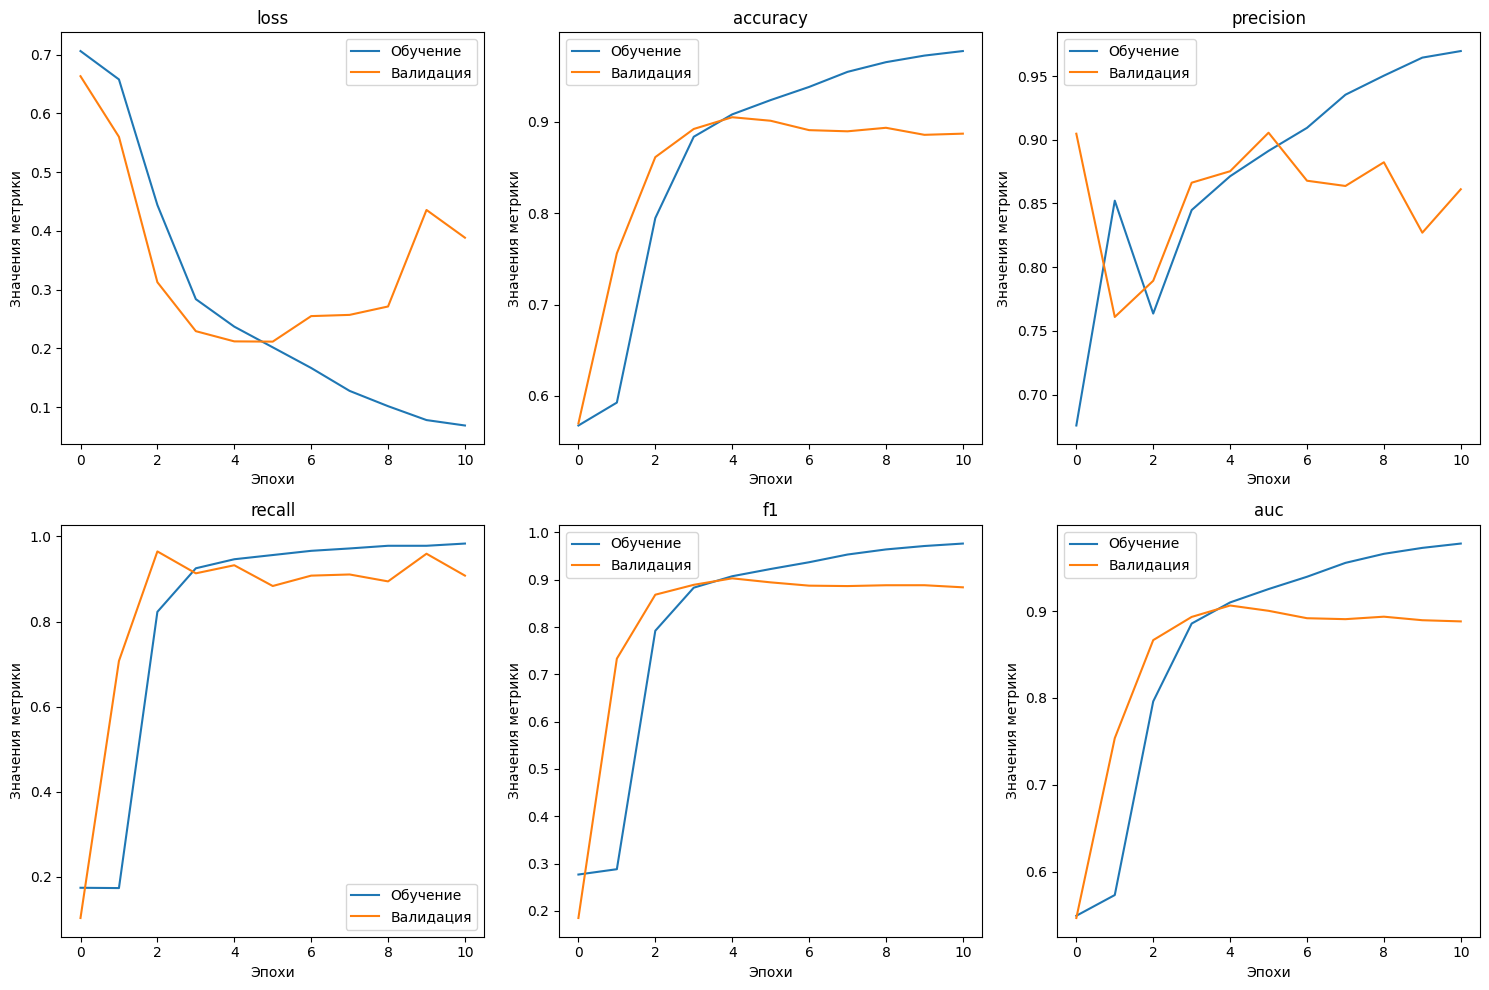

In [70]:
plot_metrics(history, 'GRU')

In [71]:
simple_gru_model.load_state_dict(torch.load('simple_GRU.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple GRU

In [72]:
loss_eval, metrics_eval, labels_eval, preds_eval = eval_model(simple_gru_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 98/98 [00:00<00:00, 110.48it/s]


In [73]:
print(loss_eval),print(metrics_eval)

0.25968195057036925
{'accuracy': 0.8950577663671374, 'precision': 0.908716540837337, 'recall': 0.8722002635046113, 'F1': 0.8900840336134453, 'AUC': 0.8944856136046211, 'loss': 0.25968195057036925}


(None, None)

In [74]:
labels_eval = np.array(labels_eval, dtype=np.int32)
preds_eval = np.array(preds_eval, dtype=np.int32)

show_metrics(labels_eval, preds_eval, f'Репорт GRU')


                Репорт GRU
 auc: 0.8944856136046211             
 report:                                
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1598
           1       0.91      0.87      0.89      1518

    accuracy                           0.90      3116
   macro avg       0.90      0.89      0.89      3116
weighted avg       0.90      0.90      0.89      3116


    


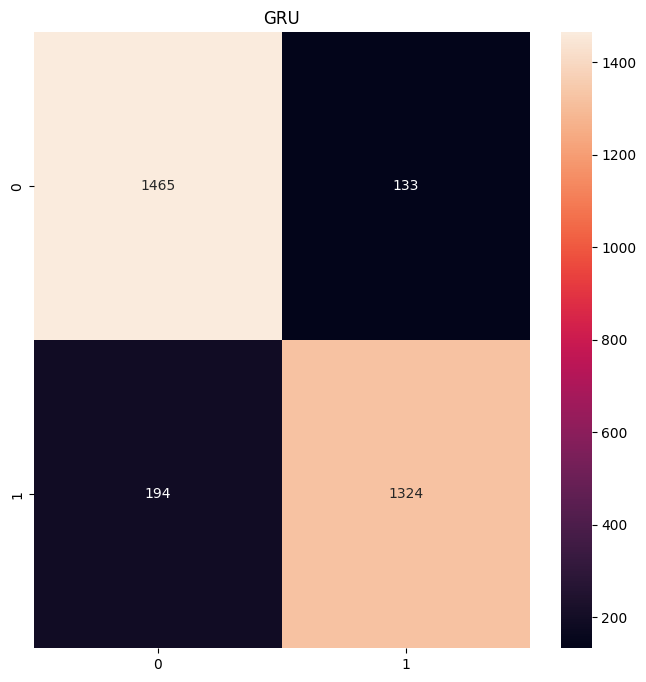

In [75]:
show_confusion_matrix(labels_eval, preds_eval, 'GRU')

In [76]:
# metrics_eval

['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8951, 0.9087, 0.8722, 0.8901, 0.8945, 0.2597]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


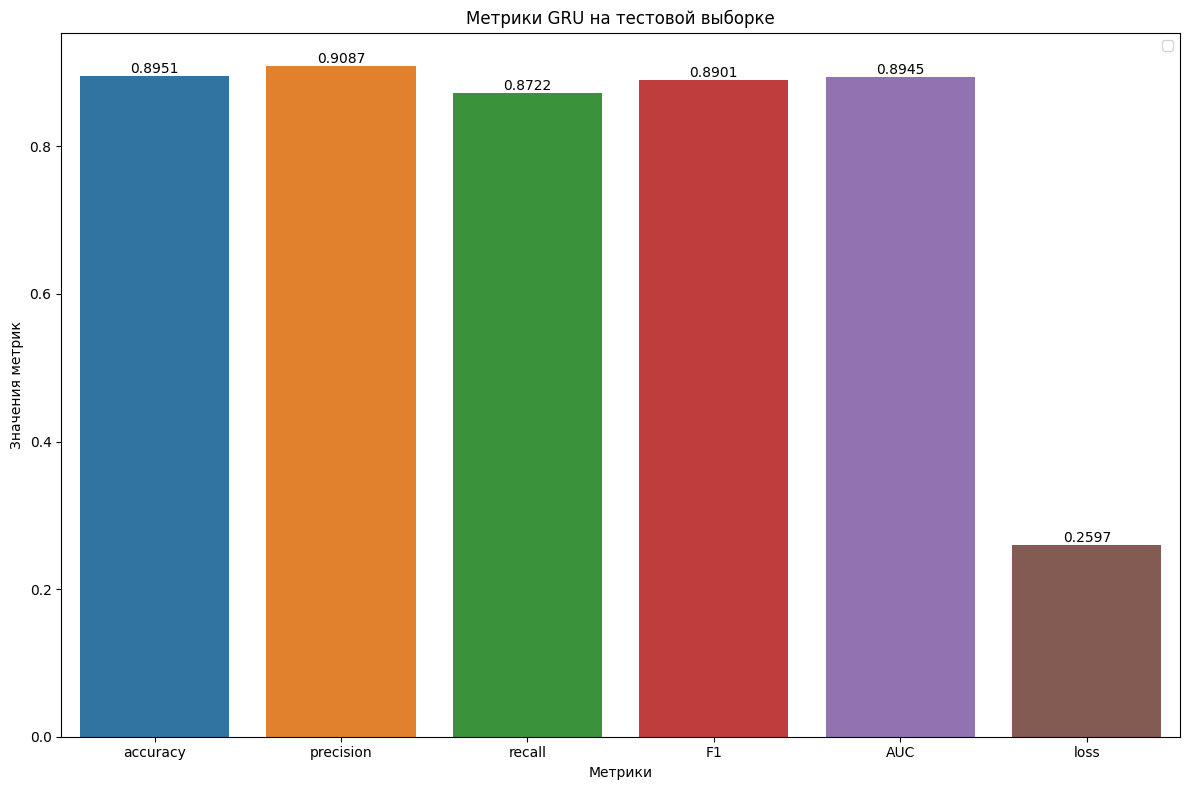

In [77]:
plot_metrics_eval(metrics_eval,'GRU')

# Bidirectional LSTM

In [78]:
class Bid_Lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate, num_layers):
        super(Bid_Lstm_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        # self.embedding.weight.requires_grad = False # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout= dropout_rate if num_layers > 1 else 0,
                           )
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm_2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out,_ = self.lstm(embedded)
        # lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        lstm_out = torch.max(lstm_out, dim=1)[0]
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.batch_norm_1(fc1_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.batch_norm_2(fc2_out)
        fc2_out = self.relu(fc2_out)
        fc2_out = self.dropout2(fc2_out)
        
        output = self.fc3(fc2_out)
        return output
        

In [79]:
# print(simple_lstm_model)

## Обучение

In [80]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
num_layers = 1
dropout_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [81]:

bid_simple_lstm_model = Bid_Lstm_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate,
                              num_layers=num_layers)

In [82]:
init_weights(bid_simple_lstm_model)

In [83]:
print(bid_simple_lstm_model)

Bid_Lstm_model(
  (embedding): Embedding(27338, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [84]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(bid_simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=4, delta=0.001, save_path='bid_lstm_model.pth')

In [85]:
bid_simple_lstm_model.to(device)

Bid_Lstm_model(
  (embedding): Embedding(27338, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [86]:
history, grad_logs = train_model(bid_simple_lstm_model,
                      train_loader, 
                      valid_loader, 
                      criterion, 
                      optimizer, 
                      device, 
                      num_epochs,
                      early_stopping = early_stopping  
                     )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:08<14:30,  8.80s/it]

Train Loss: 0.3589 | Train Acc: 0.8456 |  Train Precision: 0.8110 | Train Recall: 0.8803 |  Train F1: 0.8442 | Train AUC: 0.8472
Val Loss: 0.2671 | Val Acc: 0.8858 |  Val Precision: 0.8182 | Val Recall: 0.9756 |  Val F1: 0.8900 | Val AUC: 0.8902
Best loss: 0.26709698513150215

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:17<14:13,  8.71s/it]

Train Loss: 0.2644 | Train Acc: 0.8961 |  Train Precision: 0.8602 | Train Recall: 0.9332 |  Train F1: 0.8952 | Train AUC: 0.8979
Val Loss: 0.4049 | Val Acc: 0.8293 |  Val Precision: 0.8554 | Val Recall: 0.7696 |  Val F1: 0.8103 | Val AUC: 0.8263

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [00:26<14:11,  8.77s/it]

Train Loss: 0.2425 | Train Acc: 0.9056 |  Train Precision: 0.8681 | Train Recall: 0.9449 |  Train F1: 0.9049 | Train AUC: 0.9074
Val Loss: 0.3657 | Val Acc: 0.8408 |  Val Precision: 0.8412 | Val Recall: 0.8184 |  Val F1: 0.8297 | Val AUC: 0.8397

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [00:35<14:11,  8.87s/it]

Train Loss: 0.2228 | Train Acc: 0.9139 |  Train Precision: 0.8789 | Train Recall: 0.9496 |  Train F1: 0.9129 | Train AUC: 0.9155
Val Loss: 0.4348 | Val Acc: 0.8485 |  Val Precision: 0.8724 | Val Recall: 0.7967 |  Val F1: 0.8329 | Val AUC: 0.8459

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [00:44<17:45, 11.10s/it]

Train Loss: 0.2111 | Train Acc: 0.9194 |  Train Precision: 0.8842 | Train Recall: 0.9555 |  Train F1: 0.9185 | Train AUC: 0.9211
Val Loss: 0.2803 | Val Acc: 0.8755 |  Val Precision: 0.8736 | Val Recall: 0.8618 |  Val F1: 0.8677 | Val AUC: 0.8748
Early stopping triggered! Best model weights saved.
Stop after 4 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


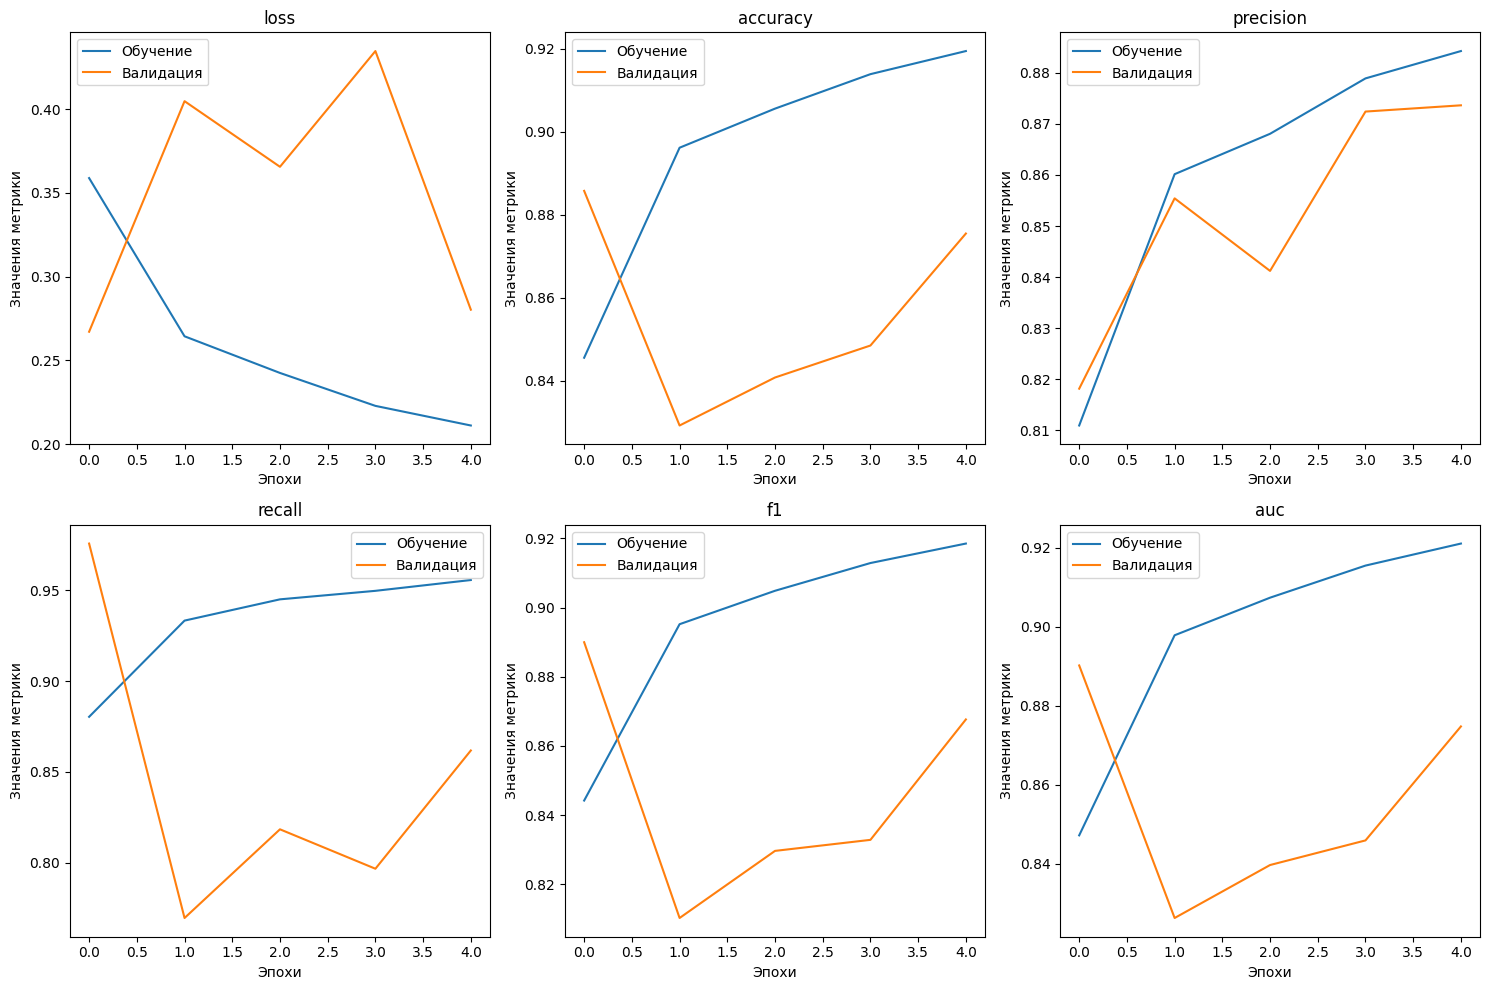

In [87]:
plot_metrics(history, 'Двунаправленная LSTM')

In [88]:
bid_simple_lstm_model.load_state_dict(torch.load('bid_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка

In [89]:
loss_eval, history_eval, labels, preds = eval_model(bid_simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 98/98 [00:01<00:00, 82.44it/s]


In [90]:
show_metrics(labels, preds, 'Двунаправленная LSTM')


                Двунаправленная LSTM
 auc: 0.8941764326620396             
 report:                                
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      1598
         1.0       0.83      0.98      0.90      1518

    accuracy                           0.89      3116
   macro avg       0.90      0.89      0.89      3116
weighted avg       0.91      0.89      0.89      3116


    


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8918, 0.8264, 0.9848, 0.8987, 0.8942, 0.2817]


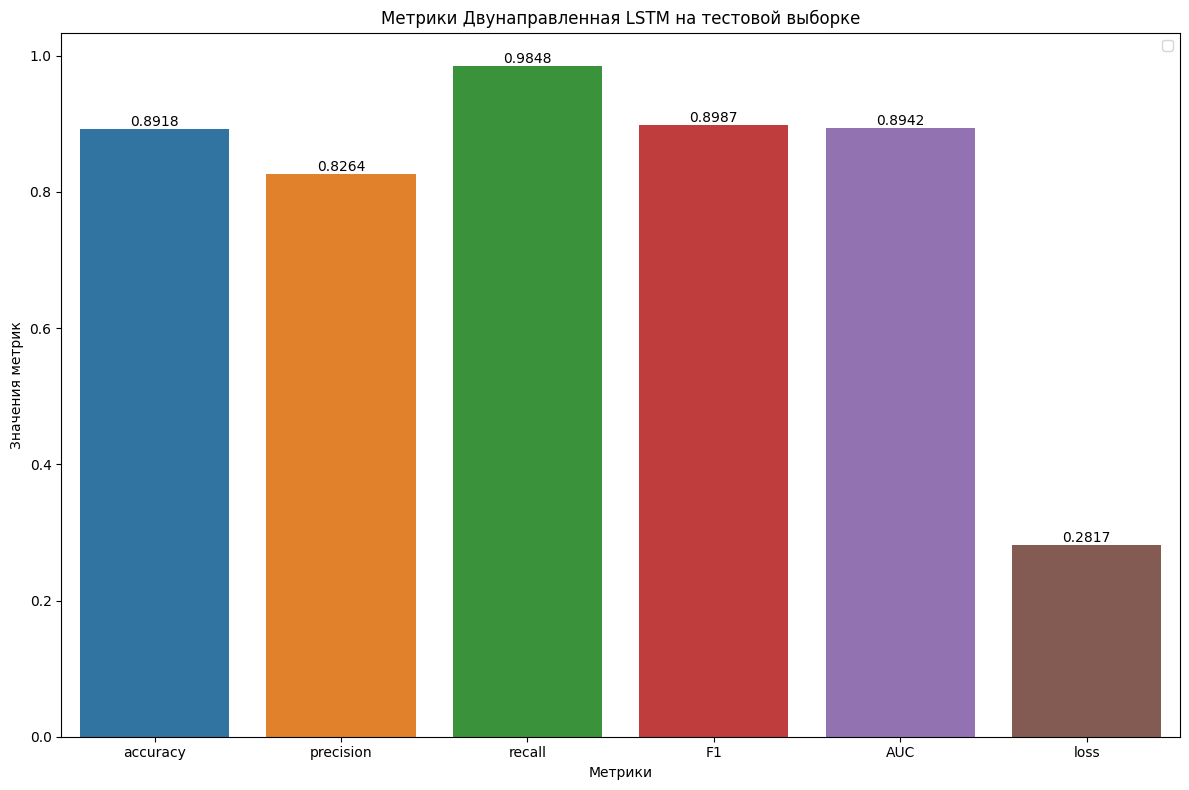

In [91]:
plot_metrics_eval(history_eval, "Двунаправленная LSTM")

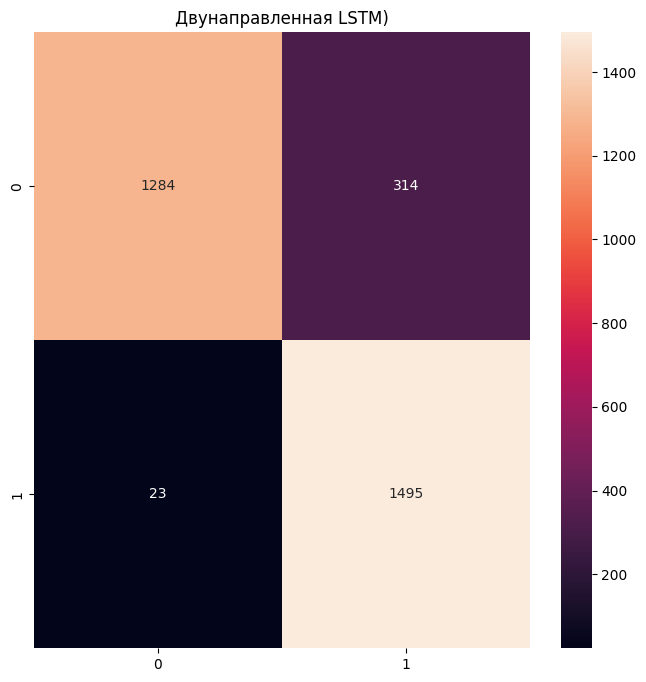

In [92]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM)')

# LSTM + CNN

In [93]:
class lstm_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernel_size, output_dim, dropout_rate, num_layers):
       super(lstm_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       self.conv1 = nn.Conv1d(in_channels = hidden_dim * 2, 
                              out_channels=num_filters, 
                              kernel_size=kernel_size,
                              padding='same')
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters, output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_out = self.conv1(lstm_out)
       conv_out = self.bn(conv_out)
       conv_out = self.relu(conv_out)
       pool = F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
       pool = self.dropout(pool)
       # print("Размер перед fc:", pool.shape)
       out = self.fc1(pool)
       return out

## Обучение LSTM + CNN

In [94]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernel_size = 3
num_filters = 128
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [95]:
lstm_cnn_model = lstm_cnn(vocab_size=len(vocabulary), 
                          embedding_matrix=embedding_matrix,
                          embedding_dim=embedding_dim,
                          hidden_dim=hidden_dim,
                          num_layers=num_layers,
                          num_filters=num_filters,
                          kernel_size=kernel_size,
                          output_dim=output_dim,
                          dropout_rate=0.25
                         )

In [96]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_cnn.pth")
lstm_cnn_model.to(device)

lstm_cnn(
  (embedding): Embedding(27338, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [97]:
print(lstm_cnn_model)

lstm_cnn(
  (embedding): Embedding(27338, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


In [98]:
history, _ = train_model(model=lstm_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:11<19:30, 11.82s/it]

Train Loss: 0.4702 | Train Acc: 0.7930 |  Train Precision: 0.7774 | Train Recall: 0.7909 |  Train F1: 0.7841 | Train AUC: 0.7929
Val Loss: 0.5189 | Val Acc: 0.7882 |  Val Precision: 0.6969 | Val Recall: 0.9783 |  Val F1: 0.8140 | Val AUC: 0.7977
Best loss: 0.5188586935400963

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:23<18:47, 11.51s/it]

Train Loss: 0.3437 | Train Acc: 0.8546 |  Train Precision: 0.8480 | Train Recall: 0.8458 |  Train F1: 0.8469 | Train AUC: 0.8542
Val Loss: 0.2833 | Val Acc: 0.8575 |  Val Precision: 0.8933 | Val Recall: 0.7940 |  Val F1: 0.8407 | Val AUC: 0.8543
Best loss: 0.2832801230251789

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [00:34<18:23, 11.38s/it]

Train Loss: 0.3078 | Train Acc: 0.8732 |  Train Precision: 0.8579 | Train Recall: 0.8789 |  Train F1: 0.8682 | Train AUC: 0.8735
Val Loss: 0.4853 | Val Acc: 0.8177 |  Val Precision: 0.7275 | Val Recall: 0.9837 |  Val F1: 0.8364 | Val AUC: 0.8260

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [00:45<18:09, 11.35s/it]

Train Loss: 0.2819 | Train Acc: 0.8841 |  Train Precision: 0.8644 | Train Recall: 0.8969 |  Train F1: 0.8803 | Train AUC: 0.8847
Val Loss: 0.2610 | Val Acc: 0.8858 |  Val Precision: 0.8349 | Val Recall: 0.9458 |  Val F1: 0.8869 | Val AUC: 0.8888
Best loss: 0.26104148104786873

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [00:56<17:56, 11.33s/it]

Train Loss: 0.2620 | Train Acc: 0.8942 |  Train Precision: 0.8754 | Train Recall: 0.9064 |  Train F1: 0.8906 | Train AUC: 0.8947
Val Loss: 0.2518 | Val Acc: 0.8858 |  Val Precision: 0.8535 | Val Recall: 0.9160 |  Val F1: 0.8837 | Val AUC: 0.8873
Best loss: 0.251774575561285

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [01:08<17:44, 11.33s/it]

Train Loss: 0.2382 | Train Acc: 0.9044 |  Train Precision: 0.8846 | Train Recall: 0.9186 |  Train F1: 0.9013 | Train AUC: 0.9050
Val Loss: 0.2597 | Val Acc: 0.9024 |  Val Precision: 0.8513 | Val Recall: 0.9621 |  Val F1: 0.9033 | Val AUC: 0.9054

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [01:19<17:33, 11.32s/it]

Train Loss: 0.2280 | Train Acc: 0.9097 |  Train Precision: 0.8908 | Train Recall: 0.9233 |  Train F1: 0.9068 | Train AUC: 0.9104
Val Loss: 0.3175 | Val Acc: 0.8832 |  Val Precision: 0.8145 | Val Recall: 0.9756 |  Val F1: 0.8878 | Val AUC: 0.8878

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [01:30<17:21, 11.32s/it]

Train Loss: 0.2215 | Train Acc: 0.9101 |  Train Precision: 0.8904 | Train Recall: 0.9246 |  Train F1: 0.9072 | Train AUC: 0.9108
Val Loss: 0.2405 | Val Acc: 0.8935 |  Val Precision: 0.8803 | Val Recall: 0.8970 |  Val F1: 0.8886 | Val AUC: 0.8936
Best loss: 0.24045674689114094

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [01:42<17:07, 11.29s/it]

Train Loss: 0.2139 | Train Acc: 0.9129 |  Train Precision: 0.8956 | Train Recall: 0.9246 |  Train F1: 0.9098 | Train AUC: 0.9135
Val Loss: 0.2611 | Val Acc: 0.8947 |  Val Precision: 0.8596 | Val Recall: 0.9295 |  Val F1: 0.8932 | Val AUC: 0.8965

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [01:53<16:56, 11.29s/it]

Train Loss: 0.1968 | Train Acc: 0.9207 |  Train Precision: 0.9018 | Train Recall: 0.9350 |  Train F1: 0.9181 | Train AUC: 0.9214
Val Loss: 0.2089 | Val Acc: 0.8909 |  Val Precision: 0.8817 | Val Recall: 0.8889 |  Val F1: 0.8853 | Val AUC: 0.8908
Best loss: 0.208920044824481

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [02:04<16:41, 11.26s/it]

Train Loss: 0.1771 | Train Acc: 0.9299 |  Train Precision: 0.9133 | Train Recall: 0.9420 |  Train F1: 0.9274 | Train AUC: 0.9305
Val Loss: 0.2545 | Val Acc: 0.9037 |  Val Precision: 0.8568 | Val Recall: 0.9566 |  Val F1: 0.9040 | Val AUC: 0.9064

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  12%|█▏        | 12/100 [02:15<16:29, 11.25s/it]

Train Loss: 0.1650 | Train Acc: 0.9355 |  Train Precision: 0.9208 | Train Recall: 0.9456 |  Train F1: 0.9330 | Train AUC: 0.9360
Val Loss: 0.2900 | Val Acc: 0.8973 |  Val Precision: 0.8640 | Val Recall: 0.9295 |  Val F1: 0.8956 | Val AUC: 0.8989

Epoch 13/100
--------------------
-----Обучение-----


Epochs:  13%|█▎        | 13/100 [02:27<16:17, 11.24s/it]

Train Loss: 0.1555 | Train Acc: 0.9389 |  Train Precision: 0.9215 | Train Recall: 0.9527 |  Train F1: 0.9368 | Train AUC: 0.9396
Val Loss: 0.2789 | Val Acc: 0.8947 |  Val Precision: 0.8509 | Val Recall: 0.9431 |  Val F1: 0.8946 | Val AUC: 0.8972

Epoch 14/100
--------------------
-----Обучение-----


Epochs:  14%|█▍        | 14/100 [02:38<16:08, 11.26s/it]

Train Loss: 0.1353 | Train Acc: 0.9460 |  Train Precision: 0.9333 | Train Recall: 0.9546 |  Train F1: 0.9439 | Train AUC: 0.9464
Val Loss: 0.3342 | Val Acc: 0.8922 |  Val Precision: 0.8484 | Val Recall: 0.9404 |  Val F1: 0.8920 | Val AUC: 0.8946

Epoch 15/100
--------------------
-----Обучение-----


Epochs:  14%|█▍        | 14/100 [02:49<17:23, 12.13s/it]

Train Loss: 0.1242 | Train Acc: 0.9500 |  Train Precision: 0.9391 | Train Recall: 0.9570 |  Train F1: 0.9479 | Train AUC: 0.9504
Val Loss: 0.2773 | Val Acc: 0.8793 |  Val Precision: 0.8667 | Val Recall: 0.8808 |  Val F1: 0.8737 | Val AUC: 0.8794
Early stopping triggered! Best model weights saved.
Stop after 14 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


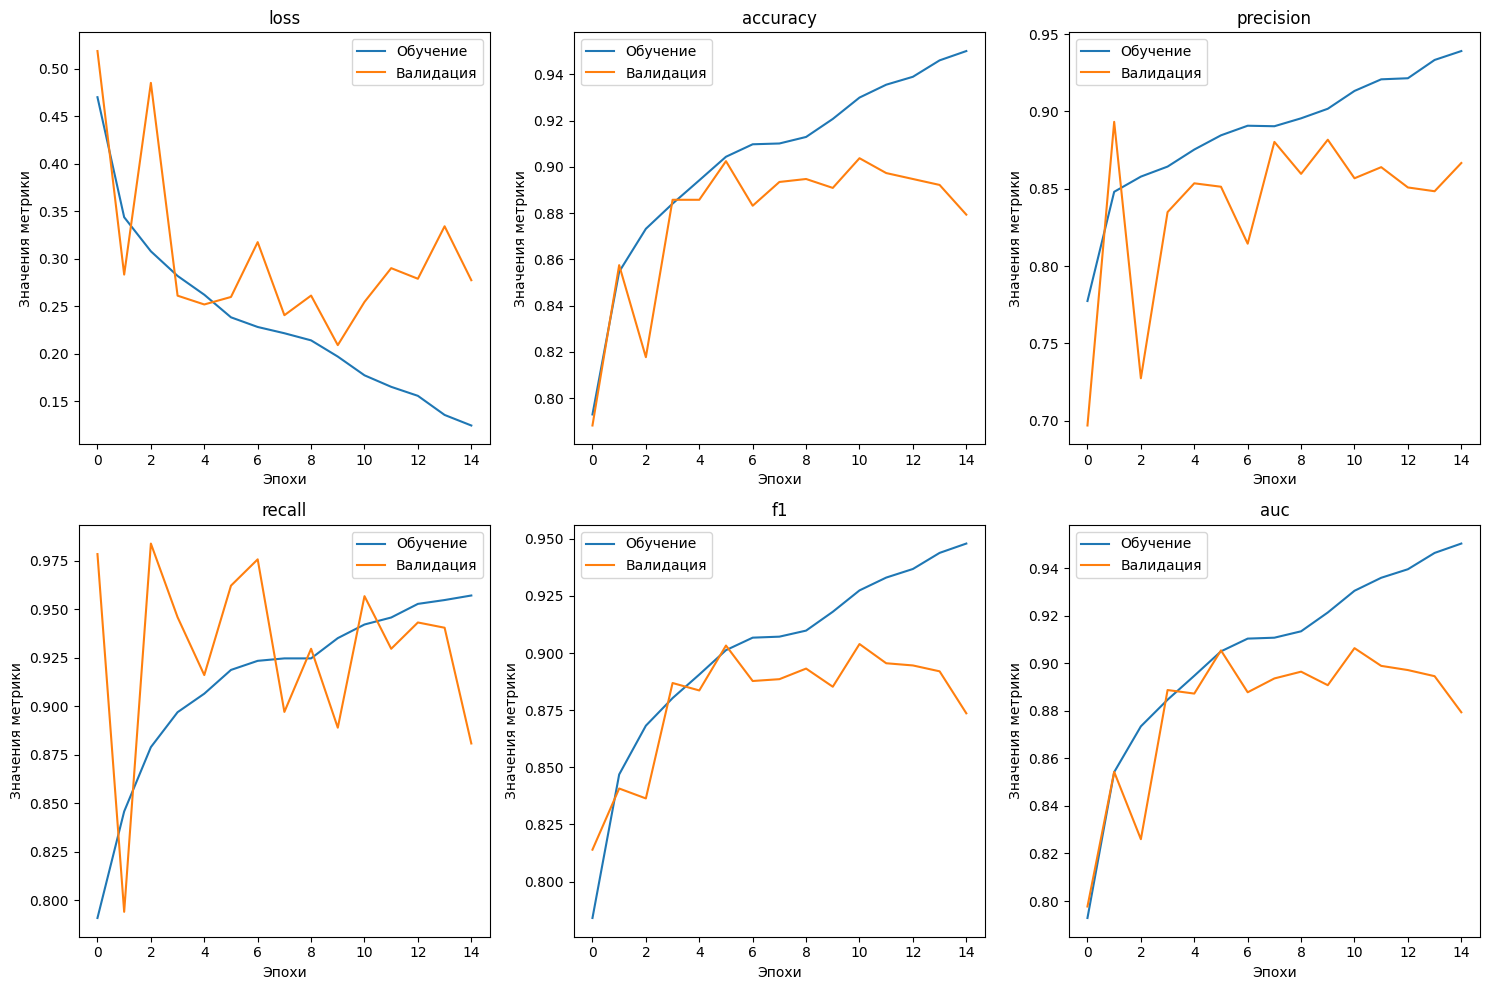

In [99]:
plot_metrics(history, "LSTM + CNN")

In [100]:
lstm_cnn_model.load_state_dict(torch.load('/kaggle/working/lstm_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + CNN

In [101]:
loss_eval, history_eval, labels, preds = eval_model(lstm_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 98/98 [00:01<00:00, 76.40it/s]


In [102]:
show_metrics(labels, preds, 'Комбинация двунаправленной LSTM и CNN')


                Комбинация двунаправленной LSTM и CNN
 auc: 0.9068380106226328             
 report:                                
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1598
         1.0       0.90      0.92      0.91      1518

    accuracy                           0.91      3116
   macro avg       0.91      0.91      0.91      3116
weighted avg       0.91      0.91      0.91      3116


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.9066, 0.895, 0.9157, 0.9052, 0.9068, 0.2503]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


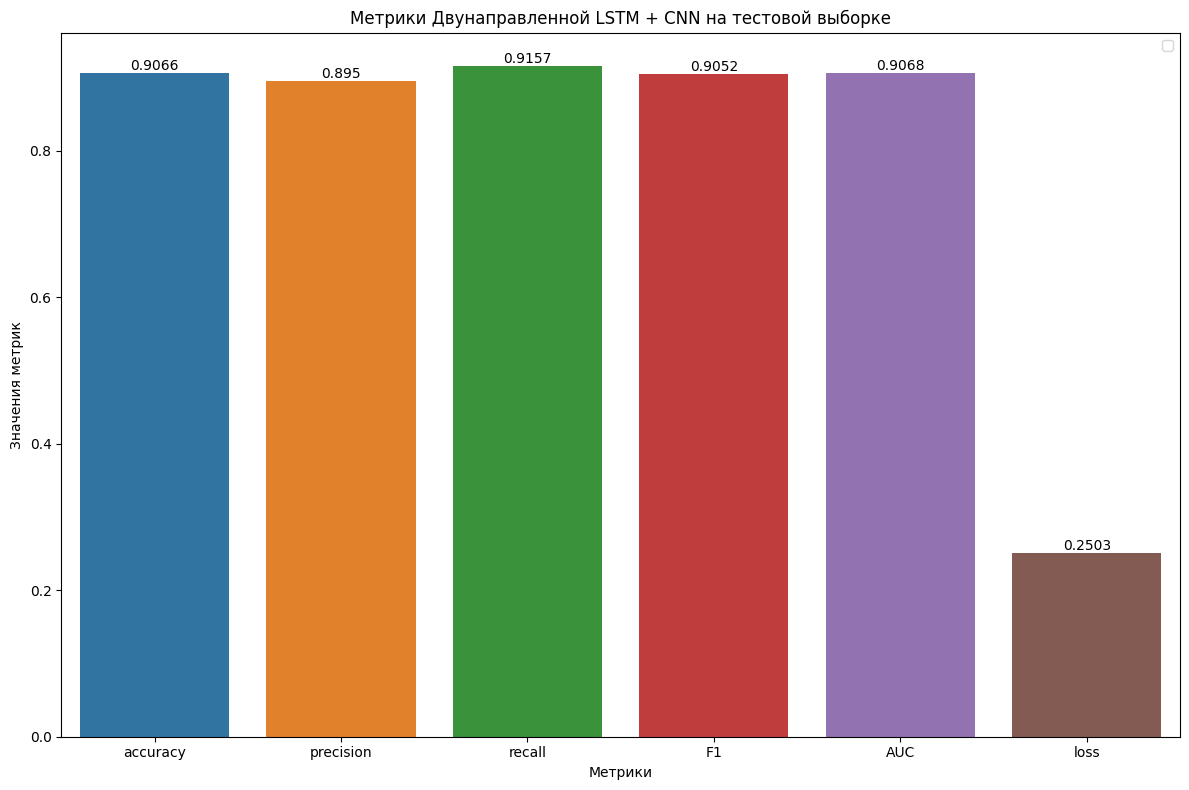

In [103]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + CNN")

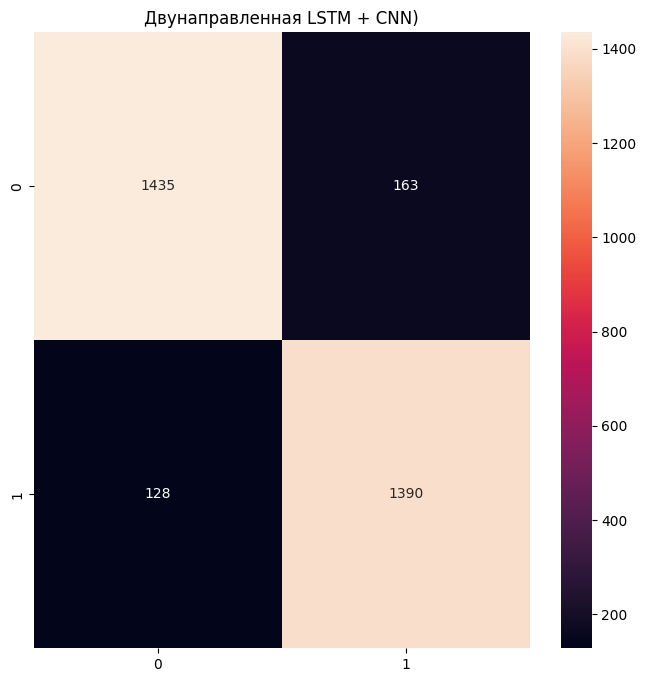

In [104]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + CNN)')

# LSTM + paralel CNN

In [105]:
class lstm_parallel_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers):
       super(lstm_parallel_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       
       # Список сверточных слоев
       self.conv_lst = nn.ModuleList([
           nn.Sequential(
               nn.Conv1d(in_channels=hidden_dim*2,out_channels=num_filters,kernel_size=ks),
               nn.BatchNorm1d(num_filters),
               nn.ReLU(),
               nn.Dropout(dropout_rate),
               nn.AdaptiveMaxPool1d(1),
               nn.Flatten()
                        ) for ks in kernels_sizes])
       
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters*len(kernels_sizes), output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_outs = [conv(lstm_out) for conv in self.conv_lst]
       conv_out_cat = torch.cat(conv_outs, dim=1)
       out = self.fc1(conv_out_cat)
       return out

## Обучение LSTM + parallel CNN

In [106]:
lstm_parallel_cnn.__init__

<function __main__.lstm_parallel_cnn.__init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers)>

In [107]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernels_sizes = [2,3,4]
num_filters = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [108]:
lstm_parallel_cnn_model = lstm_parallel_cnn(vocab_size=len(vocabulary), 
                                            embedding_matrix=embedding_matrix,
                                            embedding_dim=embedding_dim,
                                            hidden_dim=hidden_dim,
                                            num_filters=num_filters,
                                            kernels_sizes=kernels_sizes,
                                            output_dim=output_dim,
                                            dropout_rate=dropout_rate,
                                            num_layers=num_layers)
                                            

In [109]:
print(lstm_parallel_cnn_model)

lstm_parallel_cnn(
  (embedding): Embedding(27338, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [110]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_parallel_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_parallel_cnn.pth")
lstm_parallel_cnn_model.to(device)

lstm_parallel_cnn(
  (embedding): Embedding(27338, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [111]:
history, _ = train_model(model=lstm_parallel_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:18<30:09, 18.27s/it]

Train Loss: 0.6867 | Train Acc: 0.7920 |  Train Precision: 0.7877 | Train Recall: 0.7700 |  Train F1: 0.7787 | Train AUC: 0.7910
Val Loss: 0.4462 | Val Acc: 0.7099 |  Val Precision: 0.9281 | Val Recall: 0.4201 |  Val F1: 0.5784 | Val AUC: 0.6954
Best loss: 0.44615837186574936

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:36<30:05, 18.42s/it]

Train Loss: 0.3006 | Train Acc: 0.8773 |  Train Precision: 0.8648 | Train Recall: 0.8794 |  Train F1: 0.8720 | Train AUC: 0.8774
Val Loss: 0.3046 | Val Acc: 0.8780 |  Val Precision: 0.8216 | Val Recall: 0.9485 |  Val F1: 0.8805 | Val AUC: 0.8816
Best loss: 0.304595910012722

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [00:54<29:35, 18.30s/it]

Train Loss: 0.2682 | Train Acc: 0.8900 |  Train Precision: 0.8794 | Train Recall: 0.8907 |  Train F1: 0.8850 | Train AUC: 0.8900
Val Loss: 0.3047 | Val Acc: 0.8652 |  Val Precision: 0.8860 | Val Recall: 0.8211 |  Val F1: 0.8523 | Val AUC: 0.8630

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [01:13<29:10, 18.24s/it]

Train Loss: 0.2508 | Train Acc: 0.8958 |  Train Precision: 0.8838 | Train Recall: 0.8990 |  Train F1: 0.8913 | Train AUC: 0.8960
Val Loss: 0.2821 | Val Acc: 0.8729 |  Val Precision: 0.8971 | Val Recall: 0.8266 |  Val F1: 0.8604 | Val AUC: 0.8706
Best loss: 0.282148364931345

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [01:31<28:51, 18.22s/it]

Train Loss: 0.2188 | Train Acc: 0.9149 |  Train Precision: 0.9040 | Train Recall: 0.9185 |  Train F1: 0.9112 | Train AUC: 0.9150
Val Loss: 0.3043 | Val Acc: 0.8729 |  Val Precision: 0.8027 | Val Recall: 0.9702 |  Val F1: 0.8785 | Val AUC: 0.8778

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [01:49<28:31, 18.21s/it]

Train Loss: 0.2054 | Train Acc: 0.9187 |  Train Precision: 0.9092 | Train Recall: 0.9210 |  Train F1: 0.9151 | Train AUC: 0.9188
Val Loss: 0.3038 | Val Acc: 0.8742 |  Val Precision: 0.8087 | Val Recall: 0.9621 |  Val F1: 0.8787 | Val AUC: 0.8786

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [02:07<28:11, 18.19s/it]

Train Loss: 0.1974 | Train Acc: 0.9219 |  Train Precision: 0.9117 | Train Recall: 0.9253 |  Train F1: 0.9184 | Train AUC: 0.9221
Val Loss: 0.3256 | Val Acc: 0.8434 |  Val Precision: 0.9273 | Val Recall: 0.7263 |  Val F1: 0.8146 | Val AUC: 0.8375

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [02:25<27:52, 18.18s/it]

Train Loss: 0.1579 | Train Acc: 0.9376 |  Train Precision: 0.9294 | Train Recall: 0.9402 |  Train F1: 0.9348 | Train AUC: 0.9378
Val Loss: 0.3037 | Val Acc: 0.8793 |  Val Precision: 0.8176 | Val Recall: 0.9593 |  Val F1: 0.8828 | Val AUC: 0.8833

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [02:44<27:35, 18.19s/it]

Train Loss: 0.1279 | Train Acc: 0.9489 |  Train Precision: 0.9397 | Train Recall: 0.9537 |  Train F1: 0.9467 | Train AUC: 0.9492
Val Loss: 0.2686 | Val Acc: 0.8845 |  Val Precision: 0.8479 | Val Recall: 0.9214 |  Val F1: 0.8831 | Val AUC: 0.8863
Best loss: 0.26864297315478325

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [03:02<27:14, 18.16s/it]

Train Loss: 0.1172 | Train Acc: 0.9549 |  Train Precision: 0.9483 | Train Recall: 0.9573 |  Train F1: 0.9528 | Train AUC: 0.9550
Val Loss: 0.2996 | Val Acc: 0.8793 |  Val Precision: 0.8266 | Val Recall: 0.9431 |  Val F1: 0.8810 | Val AUC: 0.8825

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [03:20<26:55, 18.15s/it]

Train Loss: 0.0904 | Train Acc: 0.9682 |  Train Precision: 0.9627 | Train Recall: 0.9707 |  Train F1: 0.9667 | Train AUC: 0.9683
Val Loss: 0.2832 | Val Acc: 0.8922 |  Val Precision: 0.8554 | Val Recall: 0.9295 |  Val F1: 0.8909 | Val AUC: 0.8940

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  12%|█▏        | 12/100 [03:38<26:37, 18.15s/it]

Train Loss: 0.0775 | Train Acc: 0.9721 |  Train Precision: 0.9670 | Train Recall: 0.9746 |  Train F1: 0.9708 | Train AUC: 0.9722
Val Loss: 0.2919 | Val Acc: 0.8935 |  Val Precision: 0.8575 | Val Recall: 0.9295 |  Val F1: 0.8921 | Val AUC: 0.8953

Epoch 13/100
--------------------
-----Обучение-----


Epochs:  13%|█▎        | 13/100 [03:56<26:20, 18.17s/it]

Train Loss: 0.0760 | Train Acc: 0.9723 |  Train Precision: 0.9665 | Train Recall: 0.9755 |  Train F1: 0.9710 | Train AUC: 0.9724
Val Loss: 0.3443 | Val Acc: 0.8755 |  Val Precision: 0.8119 | Val Recall: 0.9593 |  Val F1: 0.8795 | Val AUC: 0.8797

Epoch 14/100
--------------------
-----Обучение-----


Epochs:  13%|█▎        | 13/100 [04:14<28:24, 19.59s/it]

Train Loss: 0.0532 | Train Acc: 0.9825 |  Train Precision: 0.9816 | Train Recall: 0.9816 |  Train F1: 0.9816 | Train AUC: 0.9825
Val Loss: 0.3422 | Val Acc: 0.8806 |  Val Precision: 0.8855 | Val Recall: 0.8591 |  Val F1: 0.8721 | Val AUC: 0.8795
Early stopping triggered! Best model weights saved.
Stop after 13 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


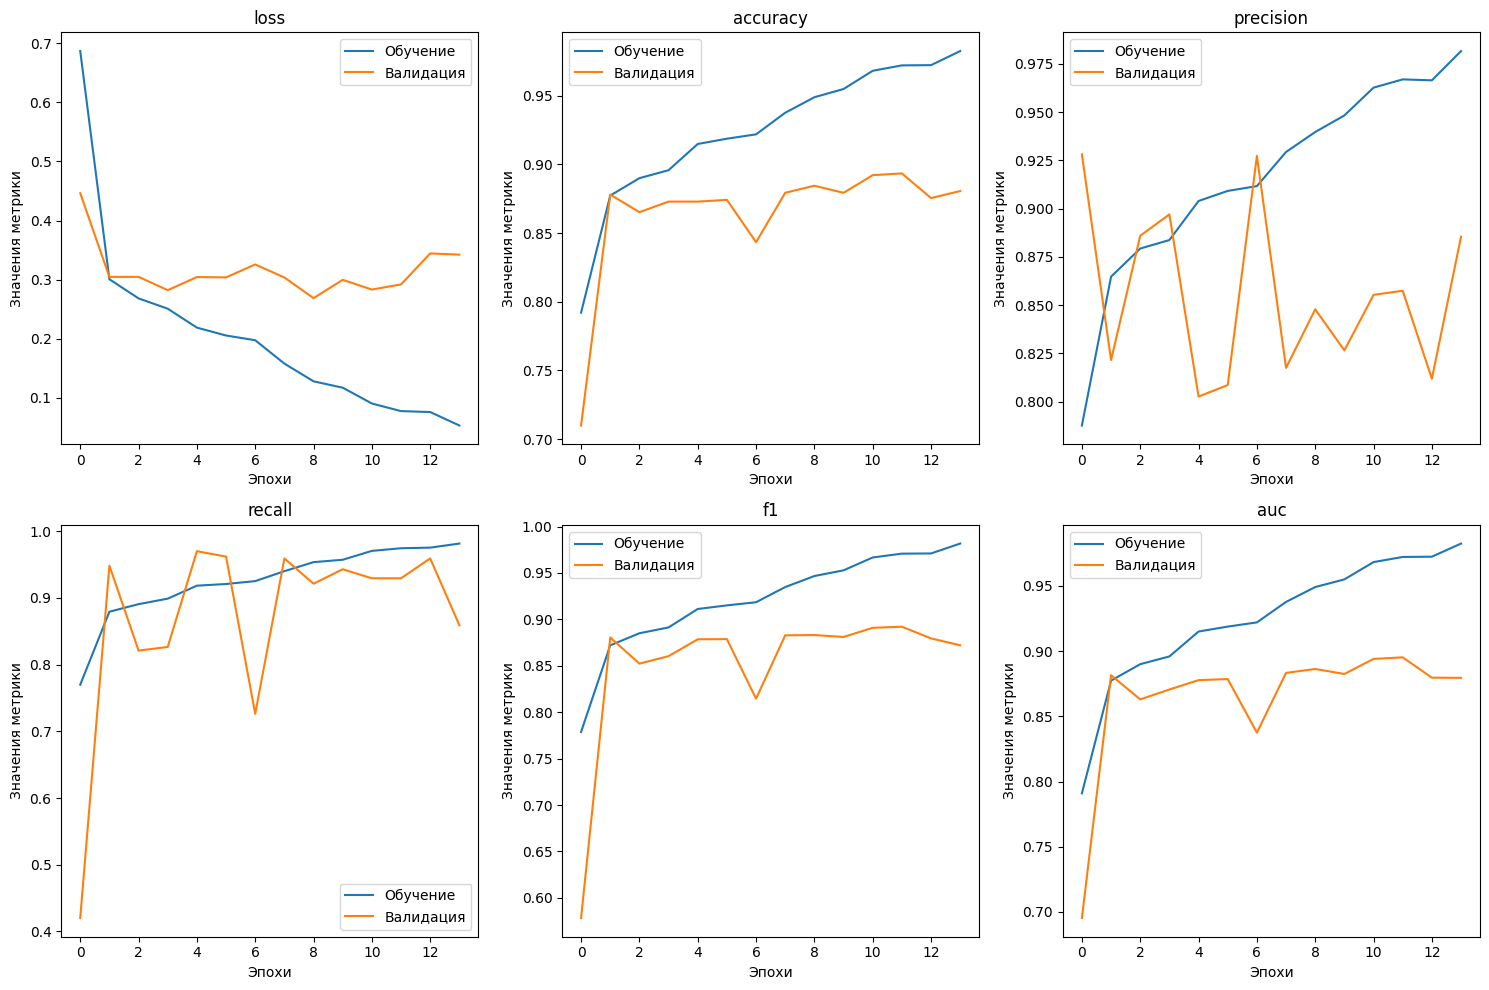

In [112]:
plot_metrics(history, "LSTM + параллельная CNN")

In [113]:
lstm_parallel_cnn_model.load_state_dict(torch.load('lstm_parallel_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + parallel CNN

In [114]:
loss_eval, history_eval, labels, preds = eval_model(lstm_parallel_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 98/98 [00:01<00:00, 53.66it/s]


In [115]:
show_metrics(labels, preds, 'Двунаправленная LSTM + параллельный CNN')



                Двунаправленная LSTM + параллельный CNN
 auc: 0.8930221571430692             
 report:                                
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      1598
         1.0       0.85      0.94      0.89      1518

    accuracy                           0.89      3116
   macro avg       0.89      0.89      0.89      3116
weighted avg       0.90      0.89      0.89      3116


    
